In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import torch.optim as optim
from IPython.core.debugger import set_trace
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

In [3]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
      
print(device)

GPU is available
cuda


In [4]:
base_csv = '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'
df = pd.read_csv(base_csv)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Analysing sentiment

### Tokenization

In [16]:
stop_words = list(set(stopwords.words('english')))

In [19]:
def preprocess_string(s):
    s = s.lower()
    s = ' '.join([word for word in s.split() if word not in stop_words])
    # replace <br /><br /> with nothing
    s = re.sub('<[^>]+>', '', s)
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", ' ', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", ' ', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    
    # remove single characters
    s = ' '.join(list(filter(lambda x: len(x)!=1, s.split())))
    

    return s

In [20]:
df.loc[:, 'review'] = df.loc[:, 'review'].apply(preprocess_string)

In [21]:
df.head()

,review,sentiment
0,one reviewers mentioned watching oz episode ho...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake thinks zombie...,negative
4,petter mattei love time money visually stunnin...,positive


In [22]:
complete = ' '.join(df['review'].tolist()).split()
counter = Counter(complete)
# words like could, would could be removed.
most_occur = counter.most_common(4)


In [23]:
counter.most_common(10)

[('movie', 87935),
 ('film', 79675),
 ('one', 53585),
 ('like', 40160),
 ('good', 29737),
 ('time', 25099),
 ('even', 24856),
 ('would', 24599),
 ('story', 23108),
 ('really', 23089)]

In [24]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (37500,)
shape of test data is (12500,)


In [12]:
x_train[1]

'ohhh man talking about far bad cheesy horror flicks go movie truly class own real gem first off film originally english that okay voice dubbing truly exceptional favorite excerpt dialog and plenty came from feeling little better thirsty blood and drama play play recap interaction military scientists scene scientist you can it ll disaster military officer that science fiction he proceeds cause complete disaster like scientist predicted scene scientist if many people die military officer you know talking about he many people die scene scientist don it ll kill everyone military officer that nonsense he proceeds kill everyone scene you get idea if enough scenes really stood instant classics one scene military literally guys pointing guns two unarmed men leader yells go get em army guys one time drop guns fist fight two adversaries instant classic and worry attention detail left out movie even hip upbeat keyboard synth soundtrack set mood and trust realize review might contain spoilers man

In [25]:
def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [26]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

In [28]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


### Analysing review length

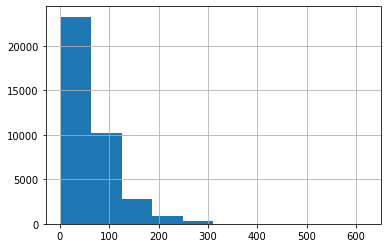

count    37500.000000
mean        67.457253
std         46.671170
min          2.000000
25%         38.000000
50%         53.000000
75%         82.000000
max        619.000000
dtype: float64

In [29]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [30]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            #features[ii, -len(review):] = np.array(review)[:seq_len]
            features[ii, :len(review)] = np.array(review)[:seq_len]
    return features

In [31]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = torch.tensor(padding_(x_train,100))
x_test_pad = torch.tensor(padding_(x_test,100))
x_train_pad.shape, x_test_pad.shape

(torch.Size([37500, 100]), torch.Size([12500, 100]))

In [32]:
x_train_pad[0]

tensor([132, 177,   2, 285, 226,  87, 556, 385, 522, 203, 293, 890,  32, 279,
         20, 558,  29,  11, 356,  38,  16, 905,  19,  79,  19,  11, 476, 830,
         41,  21,  80, 379,  41, 476, 346,  83, 242, 545,  55, 107,  93,   5,
        108, 153, 826, 265,  55,   7, 505, 242,  73, 844, 111, 428,  49, 214,
         32, 174, 156,   4,  21, 145, 204, 108,  72,  80,   3, 428,  48, 772,
         64, 407, 514, 104, 830, 809,  87, 282, 356, 251, 295, 243, 348,   5,
         56,   4,  39,  23, 284,  90,  46,  90,  14,  79,   2,  13, 192, 179,
         33, 291])

### Model

In [33]:
def get_masks(padded):
    B, T = padded.shape
    mask = torch.eq(padded, 0).to(torch.float32)
    mask = mask * -1e9
    masked_reshape = mask.reshape(B, 1, T)
    return masked_reshape

train_mask = get_masks(x_train_pad)
val_mask = get_masks(x_test_pad)
print(train_mask.shape, val_mask.shape)

torch.Size([37500, 1, 100]) torch.Size([12500, 1, 100])


In [34]:
def get_angle(timesteps, dim):
    k = np.arange(dim)[np.newaxis, :]
    i = k // 2

    positions = np.arange(timesteps)[:, np.newaxis]
    angles = positions / (10000 ** (2*i/dim))

    return angles

def get_positional_embeddings(angles):
    angles[:, 0::2] = np.sin(angles[:, 0::2])
    angles[:, 1::2] = np.cos(angles[:, 1::2])

    return torch.tensor(angles, dtype=torch.float32)

In [35]:
class Embedding(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        self.embedding_layer = nn.Embedding(n_vocab, n_embed)
        
    def forward(self, x):
        return self.embedding_layer(x)

In [36]:
class Head(nn.Module):
    def __init__(self, head_size=16):
        super().__init__()
        self.query = nn.Linear(n_embed, head_size)
        self.key = nn.Linear(n_embed, head_size)
        self.value = nn.Linear(n_embed, head_size)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x, mask):
        B, T, C = x.shape
        
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        
        wei = query @ key.transpose(-2, -1)
        
        if mask is not None:
            wei = wei + mask
        
        wei = self.softmax(wei)
        out = wei @ value # (B, T, head_size)
        
        return out

In [75]:
class Encoder(nn.Module):
    def __init__(self, n_vocab, n_embed, timesteps, head_size, output):
        super().__init__() # What happens if I pass the class name in super?
        self.embedding = Embedding(n_vocab, n_embed)
        self.sa = Head(head_size)
        self.avgpool = nn.AvgPool1d(timesteps)
        self.inter1_layer = nn.Linear(head_size, head_size)
        self.output = nn.Linear(head_size, output)
        
    def forward(self, x, mask, positional_encoding):
        B, T = x.shape # validation shape --> (1000, 73)
#         print(self.embedding(x).shape, positional_encoding.shape)
        #set_trace()
        embedding = self.embedding(x) + positional_encoding # (B, timesteps, n_embed)
        sa_out = self.sa(embedding, mask) # (B, timesteps, head_size)
        averaged = self.avgpool(sa_out.permute(0, 2, 1)) # (B, head_size, 1)
        # implement average pooling after sa_out
        inter1 = self.inter1_layer(averaged.view(B, -1)) # (B, head_size) @ (head_size, head_size) --> (B, headsize)
        output = self.output(inter1) # (B, head_size) @ (head_size, output) --> (B, output)
        
        return output

In [69]:
def train_epoch(x_batch, mask, y_batch, positional_encoding):
    optimizer.zero_grad()
    output = model(x_batch, mask, positional_encoding)
    #set_trace()
    output = nn.Sigmoid()(output)
    
    
    loss = loss_function(output.view(-1), y_batch.view(-1))
    
    correct = 0
    correct += ((output.view(-1) > 0.5).float() == y_batch).float().sum()
    accuracy = correct / y_batch.shape[0]

    loss.backward()
    optimizer.step()
    
    return loss, accuracy

In [80]:
n_embed = 32
timesteps = x_train_pad.shape[-1]
batch_size = 256
batch_per_epoch = x_train_pad.shape[0] // batch_size

train_padded, train_y = x_train_pad.to(device).long(), torch.tensor(y_train, dtype=torch.float).to(device)
val_padded, val_y = x_test_pad.to(device).long(), torch.tensor(y_test, dtype=torch.float).to(device) 
train_mask, val_mask = train_mask.to(device), val_mask.to(device)
train_positional_encoding = get_positional_embeddings(get_angle(timesteps, n_embed)).to(device)
val_positional_encoding = get_positional_embeddings(get_angle(val_padded.shape[-1], n_embed)).to(device)
print('Shape of encodings are', train_positional_encoding.shape, val_positional_encoding.shape)


model = Encoder(len(vocab)+1, n_embed, timesteps, head_size=n_embed, output=1).to(device)

loss_function = nn.BCELoss()
#loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


#model = nn.DataParallel(model, list(range(torch.cuda.device_count())))

Shape of encodings are torch.Size([100, 32]) torch.Size([100, 32])


In [40]:
def calculate_accuracy(outputs, labels):
    correct = 0
    #correct += (torch.argmax(F.softmax(outputs, dim=-1), dim=-1) == labels).float().sum()
    correct += ((outputs.view(-1) > 0.5).float() == labels).float().sum()
    return correct / labels.shape[0]

In [81]:
for epoch in range(0, 20):
    train_loss, val_loss = 0, 0
    training_accuracy = 0
    for i in range(batch_per_epoch):
        start = i * batch_size
        x_batch, y_batch, mask = train_padded[start:start+batch_size], train_y[start:start+batch_size], train_mask[start:start+batch_size]
#         x_batch, y_batch, mask = x_batch.to(device).long(), y_batch.to(device).long(), mask.to(device).long()

        model.train(True)
    
        loss, accuracy = train_epoch(x_batch, mask, y_batch, train_positional_encoding)
        train_loss += loss
        training_accuracy += accuracy
        
    print(f'Epoch {epoch} Loss: {train_loss / (i+1)}')
    print(f'Accuracy at Epoch {epoch} is {training_accuracy / (batch_per_epoch)}')
    
    model.eval()
    with torch.no_grad():
        output_val = model(val_padded, val_mask, val_positional_encoding)
        output_val = nn.Sigmoid()(output_val)
        
        loss_val = loss_function(output_val.view(-1), val_y.view(-1))
        
        accuracy = calculate_accuracy(output_val, val_y)
        
        print(f'Epoch {epoch} Val loss: {loss_val}')
        print(f'Accuracy at Epoch {epoch} is {accuracy}')
        
    print()

Epoch 0 Loss: 0.6238114237785339
Accuracy at Epoch 0 is 0.6479558944702148
Epoch 0 Val loss: 0.5718191266059875
Accuracy at Epoch 0 is 0.7010399699211121

Epoch 1 Loss: 0.5379121899604797
Accuracy at Epoch 1 is 0.7301744222640991
Epoch 1 Val loss: 0.5053843259811401
Accuracy at Epoch 1 is 0.7503199577331543

Epoch 2 Loss: 0.45939385890960693
Accuracy at Epoch 2 is 0.7803670763969421
Epoch 2 Val loss: 0.435458779335022
Accuracy at Epoch 2 is 0.7954399585723877

Epoch 3 Loss: 0.40997064113616943
Accuracy at Epoch 3 is 0.8124464750289917
Epoch 3 Val loss: 0.4054807126522064
Accuracy at Epoch 3 is 0.8119999766349792

Epoch 4 Loss: 0.3834429383277893
Accuracy at Epoch 4 is 0.8284193277359009
Epoch 4 Val loss: 0.3865524232387543
Accuracy at Epoch 4 is 0.825439989566803

Epoch 5 Loss: 0.36474302411079407
Accuracy at Epoch 5 is 0.8374893069267273
Epoch 5 Val loss: 0.3741079270839691
Accuracy at Epoch 5 is 0.8336799740791321

Epoch 6 Loss: 0.35168445110321045
Accuracy at Epoch 6 is 0.8446864485

### Training

In [94]:
imp = list()

def hook_function(module, input, output):
    #set_trace()
    if not model.training:
        #set_trace()
        imp.append(output[0].tolist())

In [83]:
#handle.remove()
for name, layer in model.named_children():
    if name == 'sa':
        for sa_name, sa_layer in layer.named_children():
            if sa_name == 'softmax':
                print(sa_name)
                handle = sa_layer.register_forward_hook(hook_function)

softmax


In [84]:
def predict_text(text):
    #set_trace()
    word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                     if preprocess_string(word) in vocab.keys()])
    word_seq = np.expand_dims(word_seq,axis=0)
    pad =  torch.from_numpy(padding_(word_seq,100))
    inputs = pad.to(device)
    test_mask = get_masks(inputs).to(device)
    batch_size = 1
    model.eval()
    output = model(inputs, test_mask, train_positional_encoding)
    output = nn.Sigmoid()(output)
    return output.item()

In [95]:
# 13000, 14000, 15000
index = 15100 
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

used fascination cartoon back college made much charm get smart admittedly faults rather enjoyable naturally interested seeing film version saw afterwords wished never made besides miscast around earth though broderick even close role make grade effects reasonable perhaps thing liked movie seeing live action version gadgets action missing story treatment made funny charming interesting original wacky cartoon lighthearted attitude fun motion picture became murky took far seriously seriously great plot went crazy enough make seem like cartoon film might enjoyable exists deserve considered part gadget legacy
Actual sentiment is  : negative
Predicted sentiment is positive with a probability of 0.6932033896446228


In [141]:
attn_imp = np.sum(np.array(imp)[0], axis=0)
cleaned_words = ' '.join([word for word in df.loc[index, 'review'].split() if preprocess_string(word) in vocab.keys()])
#colors = attn_imp * (255/np.max(attn_imp))
maxi = np.max(attn_imp); mini = np.min(attn_imp)
max_val, min_val = 255, 0
colors = min_val + (max_val - min_val) * (attn_imp - mini) / (maxi - mini)

for color, word in zip(colors.tolist(), cleaned_words.split()):
    if int(color) > 0:
        if int(color) < 30:
            r, g, b = 255, 255, 255
            print(f'\033[48;2;{int(r)};{g};{b}m{word}\033', end=' ')
        else:
            r, g, b = int(color), 0, 0
            print(f'\033[48;2;{r};{g};{b}m\033[97m{word}\033[0m', end=' ')

used cartoon back college made much get rather enjoyable interested seeing film version saw never made around earth though even close role make effects perhaps thing liked movie seeing live action version action missing story made funny interesting original cartoon fun picture became took far seriously seriously great plot went crazy enough make seem like cartoon film might enjoyable part 

In [108]:
for r in list(range(160, 255, 5)):
    #print(f'\033[48;5;{r};1;1mthis\033')
    #print(f'\033[48;5;{r}mthis\033')
    gb = 40
    print(f'\033[48;2;{r};{gb};{gb}mthis {r}\033')

this 160
this 165
this 170
this 175
this 180
this 185
this 190
this 195
this 200
this 205
this 210
this 215
this 220
this 225
this 230
this 235
this 240
this 245
this 250


In [125]:
maxi = np.max(attn_imp); mini = np.min(attn_imp)
max_val, min_val = 255, 0
print(min_val, max_val)
print(mini, maxi)

min_val + (max_val - min_val) * (attn_imp - mini) / (maxi - mini)

0 255
0.0 8.013932260901383


array([  9.68326314, 197.68982259,  40.12985196,  12.66820278,
        68.86362339,   9.33527945,   3.83375762, 112.47360991,
        39.16424706,  40.18432026,  54.18590521,  14.13333287,
        26.16636852,  79.30471863,  14.07612639,  82.15585207,
         2.33640122,  75.38474176,  10.87797196,  83.64628826,
        22.03394664,   2.95587944,  52.08846202,  25.0849615 ,
        56.69823381,   1.26216706,  55.66771688,  77.37183633,
        21.70301173, 255.        ,  74.89097646,  47.50146237,
       101.66596611,  86.3920809 ,  55.48171939,  87.88707411,
        19.46120371,  12.62414612,  55.55464479,  45.15891845,
        93.08070729,   9.13373733,   8.76981857, 100.63251284,
        30.86249149,  12.94030778,  10.56541555, 173.63062858,
         9.35418541,  38.20066011, 102.62804108,  90.32881544,
        68.73708077,  26.00578948,   9.73002099,  32.48192761,
        21.69000828,  74.13839339, 127.43331457,   8.83658373,
         0.        ,   0.        ,   0.        ,   0.  

In [122]:
def scale_array(array, min_value, max_value):
    min_array_value = min(array)
    max_array_value = max(array)
    scaled_array = []
    print(min_value, max_value)
    print(min_array_value, max_array_value)
    scaled_value = min_value + (max_value - min_value) * (array - min_array_value) / (max_array_value - min_array_value)
#     for value in array:
#         scaled_value = min_value + (max_value - min_value) * (value - min_array_value) / (max_array_value - min_array_value)
#         scaled_array.append(scaled_value)

    return scaled_value

# Example usage
array = attn_imp
min_value = 0
max_value = 255

scaled_array = scale_array(array, min_value, max_value)
print(scaled_array)  # Output: [0.0, 25.0, 50.0, 75.0, 100.0]


0 255
0.0 8.013932260901383
[  9.68326314 197.68982259  40.12985196  12.66820278  68.86362339
   9.33527945   3.83375762 112.47360991  39.16424706  40.18432026
  54.18590521  14.13333287  26.16636852  79.30471863  14.07612639
  82.15585207   2.33640122  75.38474176  10.87797196  83.64628826
  22.03394664   2.95587944  52.08846202  25.0849615   56.69823381
   1.26216706  55.66771688  77.37183633  21.70301173 255.
  74.89097646  47.50146237 101.66596611  86.3920809   55.48171939
  87.88707411  19.46120371  12.62414612  55.55464479  45.15891845
  93.08070729   9.13373733   8.76981857 100.63251284  30.86249149
  12.94030778  10.56541555 173.63062858   9.35418541  38.20066011
 102.62804108  90.32881544  68.73708077  26.00578948   9.73002099
  32.48192761  21.69000828  74.13839339 127.43331457   8.83658373
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.         